## This will be used to analyze the reversal data

In [1]:
import pandas as pd 

import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# regular GLMs
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf
%config Completer.use_jedi = False


In [2]:
# convenient function for analysis of specific conditions
def generateDistDF(array, sub_array, us, csminus, csplus, roi1, roi2, length = 8):
    # takes array (a or b), array of subjects, array of onset for each condition (us,csplus,csminus)
    # and ROIs and length of each segment
   # length = 8 # set length of TRs
    distUS_b = []
    dist_plus_b = []
    dist_minus_b = []
    for sub,v in enumerate(array):
        dist = []
        # plus US
        for i in us:
            i = int(i)
            a = np.array(array)[sub,i:i+length,roi1] 
            b = np.array(array)[sub,i:i+length,roi2] 
            dist.append(scipy.stats.spearmanr(a,b)[0])
        distUS_b.append(dist)
        # minus
        dist1 = []
        for j in csminus:
            j = int(j)
            a = np.array(array)[sub,j:j+length,roi1] 
            b = np.array(array)[sub,j:j+length,roi2] 
            dist1.append(scipy.stats.spearmanr(a,b)[0])
        dist_minus_b.append(dist1)
        # plus
        dist2 = []
        for k in csplus:
            k = int(k)
            a = np.array(array)[sub,k:k+length,roi1] 
            b = np.array(array)[sub,k:k+length,roi2] 
            dist2.append(scipy.stats.spearmanr(a,b)[0])
        dist_plus_b.append(dist2)

    distUS_b = np.array(distUS_b)
    dist_minus_b = np.array(dist_minus_b)
    dist_plus_b = np.array(dist_plus_b)

    ## generate data frame
    # first average for each subject/condition
    distPlus_mean_b = np.mean(dist_plus_b, axis=1)
    distMinus_mean_b = np.mean(dist_minus_b, axis=1)
    distUS_mean_b = np.mean(distUS_b, axis=1)
    dfDistB = pd.DataFrame({'subject': sub_array, 'minus': distMinus_mean_b, 'plusUS': distUS_mean_b, 
                           'plus': distPlus_mean_b})
    dfDistB = dfDistB.melt(id_vars='subject')
    return dfDistB, distUS_b

In [3]:
output_dir = '/gpfs/gibbs/pi/levy_ifat/Or/RV_FC'

In [4]:
# get difumo's labels
labels = pd.read_csv('/gpfs/gibbs/pi/levy_ifat/Or/DiFuMo_atlas/256/labels_256_dictionary.csv')

In [5]:
tsFiles =  glob.glob((os.path.join(output_dir, 'timeSeries','sub*.npy')))
ts_total57 = [] # the 570 timeseries
ts_total55 = [] # the 555
ts_total51 = [] # the 514
sub51 = []
sub55 = []
sub57 = []
for f in tsFiles:
    ts = np.load(f)
    sub = os.path.basename(f).split('_')[0]
    if ts.shape[0] > 545:
        # z-score
        t = ts[:548]
        tz = scipy.stats.zscore(t, axis=0)
        # append
        ts_total55.append(tz)
        sub55.append(sub)

    else:
        ts_total51.append(ts[2:])
        sub51.append(sub)
            

In [6]:
# remove items and subejcts
for i in range(len(ts_total55)):
    if ts_total55[i].shape[0] < 545:
        #print(i)
        #print(ts_total55[i].shape)
        sub55.pop(i)
        ts_total55.pop(i)
        
        
print(np.array(ts_total57).shape)
print(np.array(ts_total51).shape)
print(np.array(ts_total55).shape)        

(0,)
(24,)


/tmp/ipykernel_2680/3254487080.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(ts_total51).shape)


(89, 548, 256)


In [7]:
%matplotlib notebook # this will allow us to use interactive zoom 
# plot average timeseries of amygdala and posterior-hippocampus
#%matplotlib inline
d = pd.DataFrame(np.array(ts_total55)[:,2:,20]) # amygdala
e = pd.DataFrame(np.array(ts_total55)[:,2:,94]) # hippocampus
d = pd.melt(d)
e = pd.melt(e)

#%matplotlib notebook
plt.figure(figsize=[12,6])
sns.lineplot('variable','value', data=d)
sns.lineplot('variable','value', data=e)

UsageError: unrecognized arguments: # this will allow us to use interactive zoom


In [9]:
# now lets take the actual conditions
# we have two different sets
stimList = pd.read_csv('Behavioral/StimList.csv')
np.array(stimList.Time)/2

array([  0.,   8.,  16.,  24.,  32.,  40.,  48.,  56.,  64.,  72.,  80.,
        88.,  96., 104., 112., 120., 128., 136., 144., 152., 160., 168.,
       176., 184., 192., 200., 208., 216., 224., 232., 240., 248., 256.,
       264., 272., 280., 288., 296., 304., 312., 320., 328., 336., 344.,
       352., 360., 368., 376., 384., 392., 400., 408., 416., 424., 432.,
       440., 448., 456., 464., 472., 480., 488., 496., 504., 512., 520.,
       528., 536., 544.])

In [9]:
dfGroups = pd.read_csv('Behavioral/SubGroupLists.csv', dtype={'Sub': 'string'})
dfGroups = dfGroups[['Sub','group', 'Eprime']]
for i in dfGroups.iterrows():
    dfGroups.at[i[0], 'Sub'] = "sub-" + str(i[1].Sub)


In [10]:
# lets take just the subjects in the B list and see something how the timeline looks in different conditions
dfA = dfGroups[(dfGroups.Eprime=="A")]
dfB = dfGroups[(dfGroups.Eprime=="B")]

In [11]:
# find the subjects that matched both A list and 55 list
bothList = set(dfA.Sub).intersection(sub55)
len(bothList) # 49 subjects
# extract their time series for amygdala and hippocampus
a_array = []
sub_a = []
for i, sub in enumerate(sub55):
    if sub in bothList: # check if subject is in the list
       # print(sub)
        a_array.append(ts_total55[i])
        sub_a.append(sub)
    else:
        print(f'sub {sub} was not found in bothList')

sub sub-177 was not found in bothList
sub sub-143 was not found in bothList
sub sub-094 was not found in bothList
sub sub-011 was not found in bothList
sub sub-178 was not found in bothList
sub sub-1232 was not found in bothList
sub sub-169 was not found in bothList
sub sub-188 was not found in bothList
sub sub-190 was not found in bothList
sub sub-154 was not found in bothList
sub sub-103 was not found in bothList
sub sub-089 was not found in bothList
sub sub-135 was not found in bothList
sub sub-202 was not found in bothList
sub sub-161 was not found in bothList
sub sub-172 was not found in bothList
sub sub-196 was not found in bothList
sub sub-140 was not found in bothList
sub sub-184 was not found in bothList
sub sub-170 was not found in bothList
sub sub-025 was not found in bothList
sub sub-152 was not found in bothList
sub sub-158 was not found in bothList
sub sub-186 was not found in bothList
sub sub-137 was not found in bothList
sub sub-165 was not found in bothList
sub sub-100

In [12]:
bothListB = set(dfB.Sub).intersection(sub55)
len(bothListB) # 49 subjects
# extract their time series for amygdala and hippocampus
a_arrayB = []
sub_a_B = []
for i, sub in enumerate(sub55):
    if sub in bothListB: # check if subject is in the list
       # print(sub)
        a_arrayB.append(ts_total55[i])
        sub_a_B.append(sub)
    else:
        print(f'sub {sub} was not found in bothList')

sub sub-143 was not found in bothList
sub sub-094 was not found in bothList
sub sub-011 was not found in bothList
sub sub-167 was not found in bothList
sub sub-038 was not found in bothList
sub sub-071 was not found in bothList
sub sub-063 was not found in bothList
sub sub-168 was not found in bothList
sub sub-085 was not found in bothList
sub sub-073 was not found in bothList
sub sub-188 was not found in bothList
sub sub-179 was not found in bothList
sub sub-194 was not found in bothList
sub sub-083 was not found in bothList
sub sub-089 was not found in bothList
sub sub-135 was not found in bothList
sub sub-150 was not found in bothList
sub sub-010 was not found in bothList
sub sub-082 was not found in bothList
sub sub-053 was not found in bothList
sub sub-016 was not found in bothList
sub sub-048 was not found in bothList
sub sub-173 was not found in bothList
sub sub-032 was not found in bothList
sub sub-059 was not found in bothList
sub sub-043 was not found in bothList
sub sub-185 

In [13]:
len(a_arrayB) # 25

25

In [14]:
# now take grab condition times (from first half - before reversal)
stimList#.Time#[stimList.A=='CSplusUS1']
us1 = stimList.Time[stimList.A=="CSplusUS1"]
csminus = stimList.Time[stimList.A=="CSminus1"]
us1 = np.array(us1 /2) # turn it to TR
csminus = np.array(csminus/2)
csplus = stimList.Time[stimList.A=="CSplus1"]
csplus = np.array(csplus /2) # turn it to TR
# for the B condition
us1_b = stimList.Time[stimList.B=="CSplusUS1"]
csminus_b = stimList.Time[stimList.B=="CSminus1"]
csplus_b = stimList.Time[stimList.B=="CSplus1"]
us1_b = np.array(us1_b /2) # turn it to TR
csminus_b = np.array(csminus_b/2)
csplus_b = np.array(csplus_b / 2)

# Start Analyizing data

## Compare Amg-Hippocampus coupling
- First we compare coupling of Amg-hipp between the conditions
- Then we compare amg with vmpfc 
- Last we use control region amg-control region

In [15]:
# generate amygdala hippocampus coupling for each condition in the A timeline
dist_a_amgHipp, amg_hipp_array = generateDistDF(a_array, sub_a, us1, csminus, csplus, 20, 94, length = 8)
# in the B
dist_b_amgHipp, amg_hipp_arrayB = generateDistDF(a_arrayB, sub_a_B, us1_b, csminus_b, csplus_b, 20, 94, length = 8)

In [16]:
df_amg_hipp = pd.concat([dist_a_amgHipp, dist_b_amgHipp])
df_amg_hipp.groupby('variable').describe()

value                                                              \
         count      mean       std       min       25%       50%       75%   
variable                                                                     
minus     74.0  0.056646  0.225415 -0.446429 -0.100198  0.056548  0.216766   
plus      74.0  0.045367  0.220059 -0.434524 -0.092758  0.057540  0.197917   
plusUS    74.0  0.129975  0.243411 -0.456349  0.000992  0.121032  0.309524   

                    
               max  
variable            
minus     0.595238  
plus      0.569444  
plusUS    0.753825

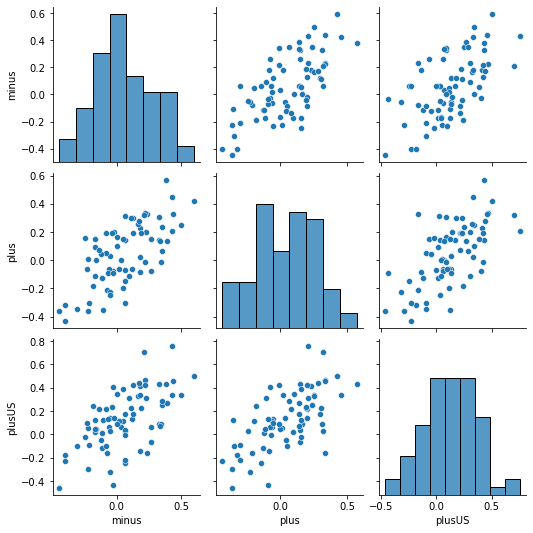

In [17]:
%matplotlib inline
df = df_amg_hipp.pivot_table(index='subject', columns= 'variable', values= 'value')
sns.pairplot(df[['minus','plus','plusUS']], kind='scatter')


/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Ttest_indResult(statistic=2.218057253184438, pvalue=0.028095358358140043)

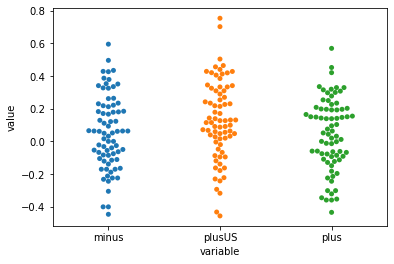

In [18]:
%matplotlib inline
sns.swarmplot('variable','value', data=df_amg_hipp)
scipy.stats.ttest_ind(df_amg_hipp.value[df_amg_hipp.variable=='plusUS'],
                      df_amg_hipp.value[df_amg_hipp.variable=='plus'])

### Summary
- We see a significant difference in the average euclidian distance between trials with US and with CS- (on the first part
- We should also compare to CS+ without US 
- We should also look at the second part

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='variable', ylabel='value'>

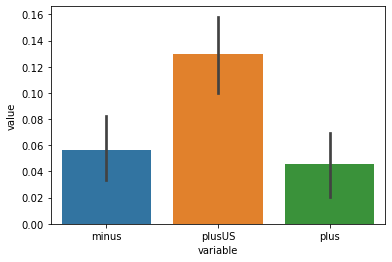

In [19]:
sns.barplot('variable','value', data=df_amg_hipp, ci=68)

In [20]:
pg.rm_anova(df_amg_hipp, dv='value', within='variable', subject='subject')

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,variable,2,146,8.209096,0.000418,0.101086,0.967404


In [21]:
glm = smf.mixedlm('value ~ variable', data=df_amg_hipp, groups = df_amg_hipp.subject, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   value  
No. Observations:     222       Method:               REML   
No. Groups:           74        Scale:                0.0190 
Min. group size:      3         Log-Likelihood:       49.2795
Max. group size:      3         Converged:            Yes    
Mean group size:      3.0                                    
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.057    0.027  2.120 0.034  0.004  0.109
variable[T.plus]   -0.011    0.023 -0.497 0.619 -0.056  0.033
variable[T.plusUS]  0.073    0.023  3.234 0.001  0.029  0.118
Group Var           0.034    0.059                           



- For robustness testing, I have tried removing the first US trial (very strong). Results still holds

### Test with vmPFC and other regions
- To make sure the effect is specific to amygdala - hippocampus

In [22]:
# generate amygdala vmpfc coupling for each condition in the A timeline
dist_a_amgVM_df, dist_a_amgVM_array = generateDistDF(a_array, sub_a, us1, csminus, csplus, 20, 42, length = 8) # 42 or 243 for anterior vmpfc
# in the B
dist_b_amgVM_df, dist_b_amgVM_array = generateDistDF(a_arrayB, sub_a_B, us1_b, csminus_b, csplus_b, 20, 42, length = 8)

df_amg_vm = pd.concat([dist_a_amgVM_df, dist_b_amgVM_df])
df_amg_vm.groupby('variable').describe()

value                                                              \
         count      mean       std       min       25%       50%       75%   
variable                                                                     
minus     74.0  0.381670  0.162581 -0.067460  0.306052  0.404762  0.479167   
plus      74.0  0.389935  0.157403  0.017857  0.295139  0.389881  0.495536   
plusUS    74.0  0.393451  0.188838 -0.321429  0.294643  0.378968  0.514881   

                    
               max  
variable            
minus     0.738095  
plus      0.769841  
plusUS    0.845238

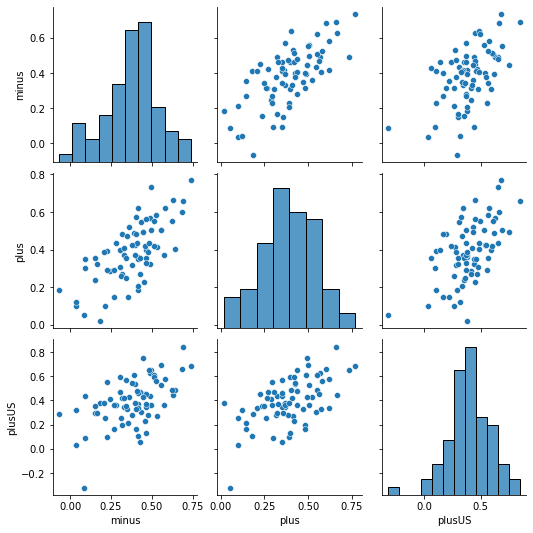

In [23]:
df = df_amg_vm.pivot_table(index='subject', columns= 'variable', values= 'value')
sns.pairplot(df[['minus','plus','plusUS']], kind='scatter')


In [24]:
pg.rm_anova(df_amg_vm, dv='value', within='variable', subject='subject')

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,variable,2,146,0.230289,0.794592,0.769645,0.003145,0.893115,False,0.880324,0.010165


In [25]:
glm = smf.mixedlm('value ~ variable', data=df_amg_vm, groups = df_amg_vm.subject, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   value   
No. Observations:   222       Method:               REML    
No. Groups:         74        Scale:                0.0118  
Min. group size:    3         Log-Likelihood:       107.8817
Max. group size:    3         Converged:            Yes     
Mean group size:    3.0                                     
------------------------------------------------------------
                   Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          0.382    0.020 19.295 0.000  0.343  0.420
variable[T.plus]   0.008    0.018  0.464 0.643 -0.027  0.043
variable[T.plusUS] 0.012    0.018  0.661 0.509 -0.023  0.047
Group Var          0.017    0.039                           



### Control region
- Using Supramarginal Gyrus

In [26]:
# generate amygdala Supramarginal gyrus anterior LH coupling for each condition in the A timeline
dist_a_amgLC = generateDistDF(a_array, sub_a, us1, csminus, csplus, 20, 250, length = 8) # 250 for Supramarginal gyrus anterior LH
# in the B
dist_b_amgLC = generateDistDF(a_arrayB, sub_a_B, us1_b, csminus_b, csplus_b, 20, 250, length = 8)
df_amg_lc = pd.concat([dist_a_amgLC[0], dist_b_amgLC[0]])
df_amg_lc.groupby('variable').describe()

value                                                              \
         count      mean       std       min       25%       50%       75%   
variable                                                                     
minus     74.0  0.137357  0.171225 -0.287698  0.052083  0.145833  0.221726   
plus      74.0  0.129344  0.159679 -0.277778  0.004960  0.128968  0.229663   
plusUS    74.0  0.173874  0.180627 -0.301587  0.041667  0.226190  0.297619   

                    
               max  
variable            
minus     0.581349  
plus      0.557540  
plusUS    0.464286

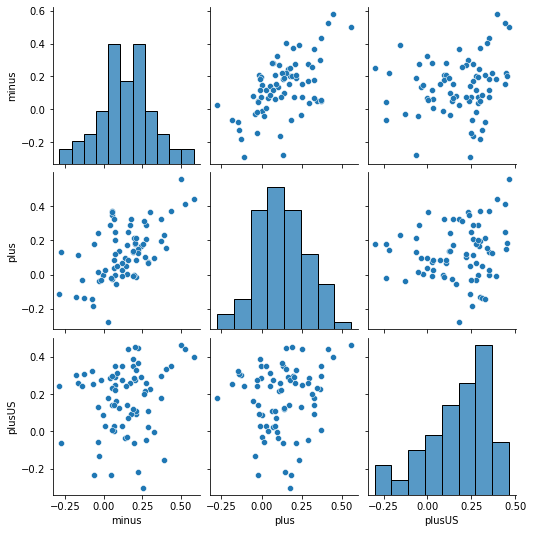

In [27]:
df = df_amg_lc.pivot_table(index='subject', columns= 'variable', values= 'value')
sns.pairplot(df[['minus','plus','plusUS']], kind='scatter')



In [28]:
pg.rm_anova(df_amg_lc, dv='value', within='variable', subject='subject')

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,variable,2,146,2.024289,0.135778,0.14432,0.026982,0.834375,False,0.801499,0.000347


In [29]:
glm = smf.mixedlm('value ~ variable', data=df_amg_lc, groups = df_amg_lc.subject, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   value  
No. Observations:     222       Method:               REML   
No. Groups:           74        Scale:                0.0206 
Min. group size:      3         Log-Likelihood:       78.4182
Max. group size:      3         Converged:            Yes    
Mean group size:      3.0                                    
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.137    0.020  6.921 0.000  0.098  0.176
variable[T.plus]   -0.008    0.024 -0.340 0.734 -0.054  0.038
variable[T.plusUS]  0.037    0.024  1.548 0.122 -0.010  0.083
Group Var           0.009    0.022                           



/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## Summary:
- Using spearman (can be pearson) correlation with 8 TR after event (i.e. maximum difference between events):
    1. Amygdala - Hippocampus highly coupled when CS+US compared to other conditions
    2. Amygdala - vmPFC not coupled
    3. Using supramarginal gyrus asr control region- no difference between the conditions in coupling
- These results suggest there's a possibility the amygdala-hippocampus are biomarker of aversive learning.

# Test correlation of amg-hipp coupling with other learning markers
#### Use amg-hipp coupling on CS+ (without US)
- These suppose to be extinction trial

#### Use amg-hipp coupling with amygdala activation

- Not sure its great idea, maybe amygdala activation in CS+ without US

#### Use amg-hipp coupling with SCR

- Here we will take the SCR score in the trial following US (or the actual trial)

In [31]:
# check cs+US coupling correlation with CS+ coupling in the next trial(s)

# grab CS+US trials amg-hipp r
# grab next trial (CS+ ) amg-hipp r
# run for all subjects
# end with two vectors of r's and correlate them

# first lets mark the cs+us and the consecutive cs+
stimListA = stimList[['Trial', 'A', 'Time']]
# remove cs-
stimListA = stimListA[(stimListA['A']!='CSminus1') & (stimListA['A']!='CSminus2') & (stimListA['A']!='CSplus2')
                     & (stimListA['A']!='CSplusUS2') * (stimListA['A']!='CSminusUS2')]
stimListA
# build vectors of cs+us and cs+
usCoup = np.array([0,48,160,272,368]) / 2
csCoup = np.array([32, 80, 176, 304, 400]) /2

In [32]:
stimListB = stimList[['Trial', 'B', 'Time']]
# remove cs-
stimListB = stimListB[(stimListB['B']!='CSminus1') & (stimListB['B']!='CSminus2') & (stimListB['B']!='CSplus2')
                     & (stimListB['B']!='CSplusUS2') * (stimListB['B']!='CSminusUS2')]
stimListB
# build vectors of cs+us and cs+
usCoup_b = np.array([0,48,96,160,256,384]) / 2
csCoup_b = np.array([16, 80, 128, 176,304,400]) /2

## Correlation between amg-hipp coupling in CS+US vs. CS+
- Taking only CS+ following the CS+US

In [33]:
def makeAmgHippCorr(usCoup, csCoup, array):
    corTotal = [] # get correlation between US and CS

    for i in array:#list(range(len(a_array))):
        uscorPerSub = []
        cscorPerSub = []
        for loc in np.arange(len(usCoup)):

            amgUS = i[int(usCoup[loc]):int(usCoup[loc]+8),20]
            hippUS = i[int(usCoup[loc]):int(usCoup[loc]+8),94]
            amgCS = i[int(csCoup[loc]):int(csCoup[loc]+8),20]
            hippCS = i[int(csCoup[loc]):int(csCoup[loc]+8),94]
            uscor = scipy.stats.spearmanr(amgUS,hippUS)[0]
            cscor = scipy.stats.spearmanr(amgCS,hippCS)[0]
            uscorPerSub.append(uscor)
            cscorPerSub.append(cscor)
        #UScorTotal_a.append(uscorPerSub)
        #CScorTotal_a.append(cscorPerSub)
        corTotal.append(scipy.stats.pearsonr(uscorPerSub, cscorPerSub)[0])
    return corTotal
    

In [34]:
corTotal_a = makeAmgHippCorr(usCoup, csCoup, a_array)
dfCoupling = pd.DataFrame({'subject': sub_a,'cor': corTotal_a})# 'USCor': UScorTotal_a, 'CSCor': CScorTotal_a})

In [35]:
corTotal_b = makeAmgHippCorr(usCoup_b, csCoup_b, a_arrayB )
dfCoupling_b = pd.DataFrame({'subject': sub_a_B,'cor': corTotal_b})

In [36]:
dfCoupling_both = pd.concat([dfCoupling, dfCoupling_b])

In [37]:
dfCoupling1 = pd.merge(dfCoupling_both, dfGroups, left_on='subject', right_on='Sub')
dfCoupling1.groupby('group').describe()


cor                                                              \
      count      mean       std       min       25%       50%       75%   
group                                                                     
HC     21.0  0.061640  0.521724 -0.806406 -0.406481  0.034956  0.546025   
VCC    28.0 -0.218841  0.522980 -0.954720 -0.557052 -0.304623  0.012561   
VPTSD  25.0  0.101440  0.424249 -0.861399 -0.204559  0.079986  0.398250   

                 
            max  
group            
HC     0.970811  
VCC    0.829057  
VPTSD  0.841320

In [38]:
# simple regression model
simple_reg = smf.ols('cor ~ C(group)', data=dfCoupling1).fit()
print(simple_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                    cor   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     3.326
Date:                Wed, 20 Oct 2021   Prob (F-statistic):             0.0416
Time:                        05:36:44   Log-Likelihood:                -50.901
No. Observations:                  74   AIC:                             107.8
Df Residuals:                      71   BIC:                             114.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0616      0.10

In [39]:
pg.anova(data=dfCoupling1, dv='cor', between='group', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,group,1.606692,2,0.803346,3.326127,0.04161,0.085667
1,Within,17.148348,71,0.241526,NaN,NaN,NaN


<AxesSubplot:xlabel='group', ylabel='cor'>

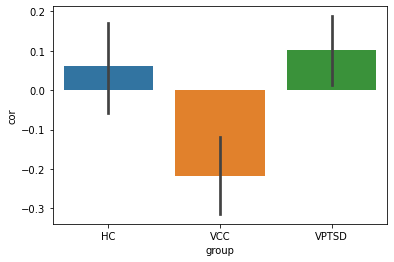

In [40]:
# plot
#sns.swarmplot(x='group',y='cor', data=dfCoupling1)
sns.barplot(x='group',y='cor', data=dfCoupling1, ci=68)

## Summary
- Interesting difference between the combat controls and PTSD 
- PTSD show higher correlation between coupling of amg-hippocampus in CS+US and CS+
- CC show lower (negative) correlation between the two - fitting extinction
* So - it might show the mechanism in which extinction doesn't work in PTSD?
- Because PTSD and HC are similar, maybe what we see here is some kind of resciliencey by the CC?

## Use Amygdala activation
- Take amygdala activation in the trials following
Here we need to think which exact window of activation do we want (time zero + something? or from time zero?)


In [41]:
# use the same method to take average amygdala activation during US and CS+ (following US)
# then test correlation between this and amg-hipp coupling on US
corTotal = [] # get correlation between US and CS

for i in a_array:#list(range(len(a_array))):
    uscorPerSub = []
    amgCSarr = []
    amgUSarr = []
    for loc in np.arange(len(usCoup)):

        amgUS = i[int(usCoup[loc]):int(usCoup[loc]+8),20]
        hippUS = i[int(usCoup[loc]):int(usCoup[loc]+8),94]
        amgCS = np.mean(i[int(csCoup[loc]+2):int(csCoup[loc]+4),20]) # taking amygdala activation 4 seconds after and ending with 8 seconds after
        uscor = scipy.stats.spearmanr(amgUS,hippUS)[0]
        cscorAmg = scipy.stats.spearmanr(amgCS,uscor)[0]
        uscorPerSub.append(uscor)
        amgCSarr.append(amgCS)
        amgUSarr.append(amgUS)
    #UScorTotal_a.append(uscorPerSub)
    #CScorTotal_a.append(cscorPerSub)
    corTotal.append(scipy.stats.pearsonr(uscorPerSub, amgCSarr)[0])

In [42]:
corTotalB = [] # get correlation between US and CS

for i in a_arrayB:#list(range(len(a_array))):
    uscorPerSub = []
    amgCSarr = []
    amgUSarr = []
    for loc in np.arange(len(usCoup)):

        amgUS = i[int(usCoup[loc]):int(usCoup[loc]+8),20]
        hippUS = i[int(usCoup[loc]):int(usCoup[loc]+8),94]
        amgCS = np.mean(i[int(csCoup[loc]+2):int(csCoup[loc]+4),20]) # taking amygdala activation 4 seconds after and ending with 8 seconds after
        uscor = scipy.stats.spearmanr(amgUS,hippUS)[0]
        cscorAmg = scipy.stats.spearmanr(amgCS,uscor)[0]
        uscorPerSub.append(uscor)
        amgCSarr.append(amgCS)
        amgUSarr.append(amgUS)
    #UScorTotal_a.append(uscorPerSub)
    #CScorTotal_a.append(cscorPerSub)
    corTotalB.append(scipy.stats.pearsonr(uscorPerSub, amgCSarr)[0])

In [43]:
dfCouplingAMG = pd.DataFrame({'subject': sub_a,'cor': corTotal})
dfCouplingAMG_b = pd.DataFrame({'subject': sub_a_B,'cor': corTotalB})
dfCouplingAMG_both = pd.concat([dfCouplingAMG, dfCouplingAMG_b])
dfCouplingAMG_1 = pd.merge(dfCouplingAMG_both, dfGroups, left_on='subject', right_on='Sub')
dfCouplingAMG_1.groupby('group').describe()



cor                                                              \
      count      mean       std       min       25%       50%       75%   
group                                                                     
HC     21.0  0.214376  0.389251 -0.360470 -0.127745  0.234777  0.550162   
VCC    28.0  0.127052  0.453308 -0.770150 -0.189622  0.218835  0.418460   
VPTSD  25.0 -0.146533  0.469840 -0.900219 -0.306086 -0.186093  0.206187   

                 
            max  
group            
HC     0.977304  
VCC    0.847922  
VPTSD  0.783746

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,71,4.330474,0.016806,0.108723


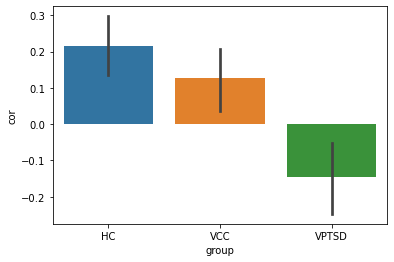

In [44]:
#sns.swarmplot(x='group',y='cor', data=dfCouplingAMG_1)
sns.barplot(x='group',y='cor', data=dfCouplingAMG_1, ci=68)
pg.anova(data=dfCouplingAMG_1, dv='cor', between='group')

In [413]:
# simple regression model
simple_reg_amgActivation = smf.ols('cor ~ C(group)', data=dfCouplingAMG_1).fit()
print(simple_reg_amgActivation.summary())

                            OLS Regression Results                            
Dep. Variable:                    cor   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     4.330
Date:                Tue, 19 Oct 2021   Prob (F-statistic):             0.0168
Time:                        15:19:37   Log-Likelihood:                -43.068
No. Observations:                  74   AIC:                             92.14
Df Residuals:                      71   BIC:                             99.05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2144      0.09

## Test amg-hipp coupling with SCR
- First: correlation between mean coupling and CS+ vs. CS- across 1st half
- Following similar method
- Grabbing SCR in the US trials and the ones following

In [65]:
# read scr file
scr_df = pd.read_csv('plus_minus.csv')
subjs = []
for i,row in scr_df.iterrows():
    sub = 'sub-' + str(row.subject)
    subjs.append(sub)
    
scr_df['subject'] = subjs
scr_df


,subject,plusMinus,group
0,sub-189,0.042992,HC
1,sub-86,-0.080975,VCC
2,sub-205,0.248292,VPTSD
3,sub-71,-0.055083,VCC
4,sub-87,0.512283,VPTSD
...,...,...,...
96,sub-83,-0.013408,VCC
97,sub-113,0.516667,VCC
98,sub-107,0.075758,VCC
99,sub-126,0.054075,HC


In [67]:
# grab only the USplus value
df_amg_plus = df_amg_hipp[df_amg_hipp.variable=='plusUS']
# merge with CS+ vs CS- SCR
df_scr_plusMinus = pd.merge(df_amg_plus, scr_df)
df_scr_plusMinus.groupby('group').corr()

pg.corr(df_scr_plusMinus.value, df_scr_plusMinus.plusMinus)

,n,r,CI95%,p-val,BF10,power
pearson,42,0.085903,"[-0.22, 0.38]",0.588564,0.221,0.084055


In [55]:
reg_amgHipp_scr = smf.rlm('plusMinus ~ C(group) * value', data=df_scr_plusMinus).fit()
reg_amgHipp_scr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:              plusMinus   No. Observations:                   42
Model:                            RLM   Df Residuals:                       36
Method:                          IRLS   Df Model:                            5
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 05 Nov 2021                                         
Time:                        03:34:26                                         
No. Iterations:                    15                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.2308      0.060      3.874      0.000       0.114       0.348
C(group)[T.VCC]            -0.0565      0.111     -0.507      0.612      -0.275       0.162
C(group)[T.VPTSD]          -0.1388      0.097     -1.430      0.153      -0.329       0.051
value                       0.1096      0.238      0.461      0.645      -0.356       0.576
C(group)[T.VCC]:value      -0.1811      0.334     -0.541      0.588      -0.837       0.474
C(group)[T.VPTSD]:value     0.1279      0.474      0.270      0.787      -0.801       1.056
===========================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

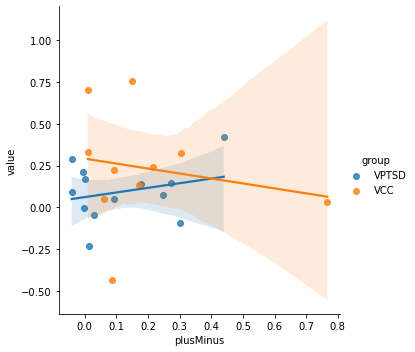

In [53]:
sns.lmplot(data=df_scr_plusMinus[df_scr_plusMinus.group!='HC'], x='plusMinus', y='value', hue='group')

## just Second half of first part

In [64]:
scr_s = pd.read_csv('plus_minus_2.csv')
subjs = []
for i,row in scr_s.iterrows():
    sub = 'sub-' + str(row.subject)
    subjs.append(sub)
    
scr_s['subject'] = subjs

df_scr_plusMinus = pd.merge(df_amg_plus, scr_s)
df_scr_plusMinus
df_scr_plusMinus.groupby('group').corr()
pg.corr(df_scr_plusMinus.value, df_scr_plusMinus.plusMinus)

,n,r,CI95%,p-val,BF10,power
pearson,42,0.064826,"[-0.24, 0.36]",0.683366,0.208,0.069044


In [45]:
# Grab SCR data
scrDat = pd.read_csv('Behavioral/SCR3.csv', dtype= {'sub': 'string'} )
scrDat = scrDat[['sub','Event.Nr','CDA.PhasicMax', 'Condition']]
# add sub to subject
for i in scrDat.iterrows():
    subNum = scrDat.at[i[0], 'sub']
    if len(subNum) < 2:
        sub = 'sub-' + '00' + subNum
       # print(sub)
    elif len(subNum) ==2:
        sub = 'sub-' + '0' + subNum
       # print(sub)
    else:
        sub = 'sub-' + subNum
    scrDat.at[i[0], 'sub'] = sub


In [46]:
# take just 1st part
scrDat = scrDat[(scrDat['Condition']!='CSminus1') & (scrDat['Condition']!='CSminus2') & 
                (scrDat['Condition']!='CSplus2')
                     & (scrDat['Condition']!='CSplusUS2') * (scrDat['Condition']!='CSminusUS2')]

In [48]:
scrSub = scrDat['sub'].unique() # grab scr subject list
scrSub = np.array(scrSub)

In [49]:
scrSubs = set(sub_a).intersection(scrSub) # find intersection between both lists
scrSubs_b = set(sub_a_B).intersection(scrSub)
len(scrSubs)

46

In [50]:
# grab each subject's scr data (only relevant one)
scr_relevant = {}
for sub in scrSubs:
    print(sub)
    scSub = scrDat[scrDat['sub']==sub]
    scSub = scSub[['sub','CDA.PhasicMax','Condition']]
   # print(scSub)
    # now grab phasicmax after US
    scr_us = [] # empty holder for list of phasicmax per subject
    csTick=0 ## set ticker for CSplusUS conditions
    for i in scSub.iterrows():
        if csTick==1: # if it was previously CSplusUS1
            # specific case when consecutive USs are in 
            if i[1]['Condition']!= 'CSplusUS1':
                print(i[1]['Condition'])
                scr_us.append(i[1]['CDA.PhasicMax'])
            else:
                csTick=1
        else:
            print('previous non US trial')
        if i[1]['Condition']=='CSplusUS1':
            csTick = 1
        else:
            csTick=0
            print('Not US trial')
        
    scr_relevant[sub] = scr_us
    

sub-059
previous non US trial
CSplus1
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
Not US trial
previous non US trial
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
Not US trial
previous non US trial
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
Not US trial
previous non US trial
Not US trial
sub-173
previous non US trial
CSplus1
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
Not US trial
previous non US trial
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
Not US trial
previous non US trial
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
Not US trial
previous non US trial
Not US trial
sub-016
previous non US trial
CSplus1
Not US trial
previous non 

previous non US trial
CSplus1
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
Not US trial
previous non US trial
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
Not US trial
previous non US trial
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
Not US trial
previous non US trial
Not US trial
sub-153
previous non US trial
CSplus1
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
Not US trial
previous non US trial
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
Not US trial
previous non US trial
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
Not US trial
previous non US trial
Not US trial
sub-055
previous non US trial
CSplus1
Not US trial
previous non US trial

In [51]:
scr_relevant_b = {}
for sub in scrSubs_b:
    print(sub)
    scSub = scrDat[scrDat['sub']==sub]
    scSub = scSub[['sub','CDA.PhasicMax','Condition']]
   # print(scSub)
    # now grab phasicmax after US
    scr_us = [] # empty holder for list of phasicmax per subject
    csTick=0 ## set ticker for CSplusUS conditions
    for i in scSub.iterrows():
        if csTick==1: # if it was previously CSplusUS1
            # specific case when consecutive USs are in 
            if i[1]['Condition']!= 'CSplusUS1':
                print(i[1]['Condition'])
                scr_us.append(i[1]['CDA.PhasicMax'])
            else:
                csTick=1
        else:
            print('previous non US trial')
        if i[1]['Condition']=='CSplusUS1':
            csTick = 1
        else:
            csTick=0
            print('Not US trial')
        
    scr_relevant_b[sub] = scr_us

sub-170
previous non US trial
CSplus1
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
Not US trial
previous non US trial
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
Not US trial
previous non US trial
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
Not US trial
previous non US trial
Not US trial
sub-193
previous non US trial
CSplus1
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
Not US trial
previous non US trial
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
Not US trial
previous non US trial
Not US trial
previous non US trial
CSplus1
Not US trial
previous non US trial
Not US trial
previous non US trial
Not US trial
sub-200
previous non US trial
CSplus1
Not US tri

In [52]:
## now I can take that and correlate with amygdala-hippocampus coupling
corTotal = {} # get correlation between US and CS

for i,sub in zip(a_array, sub_a):#list(range(len(a_array))):
    
    uscorPerSub = []
    for loc in np.arange(len(usCoup)):

        amgUS = i[int(usCoup[loc]):int(usCoup[loc]+8),20]
        hippUS = i[int(usCoup[loc]):int(usCoup[loc]+8),94]
        uscor = scipy.stats.pearsonr(amgUS,hippUS)[0]
        uscorPerSub.append(uscor)
       
    corTotal[sub]=np.array(uscorPerSub)

In [53]:
## now I can take that and correlate with amygdala-hippocampus coupling
corTotal_B = {} # get correlation between US and CS

for i,sub in zip(a_arrayB, sub_a_B):#list(range(len(a_array))):
    
    uscorPerSub = []
    for loc in np.arange(len(usCoup_b)):

        amgUS = i[int(usCoup_b[loc]):int(usCoup_b[loc]+8),20]
        hippUS = i[int(usCoup_b[loc]):int(usCoup_b[loc]+8),94]
        uscor = scipy.stats.pearsonr(amgUS,hippUS)[0]
        uscorPerSub.append(uscor)
       
    corTotal_B[sub]=np.array(uscorPerSub)

In [54]:
scrBrain_cor = {}
for sub in scrSubs:
    amgHipp = corTotal[sub] # grab amygdala hippocampus coupling
    # grab scr
    scrGrab = scr_relevant[sub]
    scrAmgHipp_correlation = scipy.stats.spearmanr(amgHipp, scrGrab)[0]
    scrBrain_cor[sub] = scrAmgHipp_correlation

In [55]:
scrBrain_cor_b = {}
for sub in scrSubs_b:
    amgHipp = corTotal_B[sub] # grab amygdala hippocampus coupling
    # grab scr
    scrGrab = scr_relevant_b[sub]
    scrAmgHipp_correlation = scipy.stats.spearmanr(amgHipp, scrGrab)[0]
    scrBrain_cor_b[sub] = scrAmgHipp_correlation

In [56]:
values = scrBrain_cor.items()
scrBrain_cor1 = pd.DataFrame(values, columns=['subject','scrCor'])
values_b = scrBrain_cor_b.items()
scrBrain_cor1_b = pd.DataFrame(values_b, columns=['subject','scrCor'])
scrBrain_both = pd.concat([scrBrain_cor1, scrBrain_cor1_b])
scrBrain_cor1 = pd.merge(scrBrain_both, dfGroups, left_on='subject', right_on='Sub')
scrBrain_cor1.groupby('group').describe()

scrCor                                                                 
       count      mean       std       min       25%  50%       75%       max
group                                                                        
HC      19.0  0.142857  0.516837 -0.828571 -0.178571  0.1  0.514286  1.000000
VCC     28.0  0.117347  0.510914 -0.900000 -0.225000  0.2  0.500000  1.000000
VPTSD   22.0  0.042857  0.528047 -0.900000 -0.482143  0.1  0.378571  0.885714

In [57]:
pg.anova(scrBrain_cor1, between='group', dv='scrCor')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,66,0.214516,0.807492,0.006458


Nothing. But should try a different approach, correlating all subjects (or just from each group) with each trial

In [58]:
# simple regression model
simple_reg_scr = smf.ols('scrCor ~ C(group)', data=scrBrain_cor1).fit()
print(simple_reg_scr.summary())

                            OLS Regression Results                            
Dep. Variable:                 scrCor   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.2145
Date:                Wed, 20 Oct 2021   Prob (F-statistic):              0.807
Time:                        06:31:04   Log-Likelihood:                -50.991
No. Observations:                  69   AIC:                             108.0
Df Residuals:                      66   BIC:                             114.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1429      0.11

### Different approach  of SCR
- Correlate each trial (i.e. all subjects/one group)

In [97]:

## now I can take that and correlate with amygdala-hippocampus coupling
corTotal = {} # get correlation between US and CS

for loc in np.arange(len(usCoup)):
    uscorPerTrial = []
    for i,sub in zip(a_array, sub_a):#list(range(len(a_array))):
        
        amgUS = i[int(usCoup[loc]):int(usCoup[loc]+8),20]
        hippUS = i[int(usCoup[loc]):int(usCoup[loc]+8),94]
        uscor = scipy.stats.pearsonr(amgUS,hippUS)[0]
        uscorPerTrial.append(uscor)
       
    corTotal[str(loc)]=np.array(uscorPerTrial)

In [98]:
## now I can take that and correlate with amygdala-hippocampus coupling
corTotal_B = {} # get correlation between US and CS

for loc in np.arange(len(usCoup_b)):
    uscorPerTrial = []
    for i,sub in zip(a_arrayB, sub_a_B):#list(range(len(a_array))):
        
        amgUS = i[int(usCoup_b[loc]):int(usCoup_b[loc]+8),20]
        hippUS = i[int(usCoup_b[loc]):int(usCoup_b[loc]+8),94]
        uscor = scipy.stats.pearsonr(amgUS,hippUS)[0]
        uscorPerTrial.append(uscor)
       
    corTotal_B[str(loc)]=np.array(uscorPerTrial)

In [177]:
scr_relevantDf = pd.DataFrame(scr_relevant).T
scr_relevantDf.columns = ['SCR1', 'SCR2','SCR3','SCR4','SCR5']
corTotal_Df = pd.DataFrame(corTotal)

corTotal_Df['subject'] = sub_a
#scr_relevantDf
corTotal_Df.columns = ['Trial1','Trial2','Trial3','Trial4', 'Trial5', 'subject']


In [178]:
scr_relevantDf_b = pd.DataFrame(scr_relevant_b).T
corTotal_Df_b = pd.DataFrame(corTotal_B)


corTotal_Df_b['subject'] = sub_a_B
#scr_relevantDf
corTotal_Df_b.columns = ['Trial1','Trial2','Trial3','Trial4', 'Trial5', 'Trial6', 'subject']
scr_relevantDf_b.columns = ['SCR1', 'SCR2','SCR3','SCR4','SCR5', 'SCR6']

In [179]:
scr_relevant_DF1 = scr_relevantDf.merge(corTotal_Df, right_on='subject', left_index=True)

In [180]:
scr_relevant_DF2 = scr_relevantDf_b.merge(corTotal_Df_b, right_on='subject', left_index=True)

<AxesSubplot:>

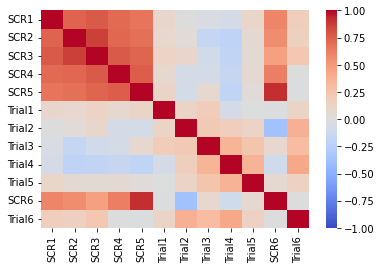

In [181]:
corTotalBoth = pd.concat([scr_relevant_DF1, scr_relevant_DF2], join='outer')
sns.heatmap(corTotalBoth.corr(), cmap='coolwarm', vmin = -1)

## Different groups

In [182]:
corTotalBoth = pd.merge(corTotalBoth, dfGroups, left_on='subject', right_on='Sub')
corTotalBoth.head()

,SCR1,SCR2,SCR3,SCR4,SCR5,Trial1,Trial2,Trial3,Trial4,Trial5,subject,SCR6,Trial6,Sub,group,Eprime
0,5.8303,0.4874,2.4339,0.4451,0.0956,0.711285,0.574210,-0.627112,-0.388868,-0.319567,sub-059,NaN,NaN,sub-059,VPTSD,A
1,2.4473,2.4104,1.8343,1.8232,1.0540,0.144986,0.263511,0.040329,0.031522,-0.042875,sub-173,NaN,NaN,sub-173,HC,A
2,0.3150,0.1579,1.3454,0.0827,0.1692,-0.561086,-0.466483,-0.851179,-0.650353,-0.364500,sub-016,NaN,NaN,sub-016,VCC,A
3,4.4168,4.4082,0.9974,1.2969,0.2091,-0.642549,-0.255462,-0.438978,-0.584554,0.512745,sub-082,NaN,NaN,sub-082,VCC,A
4,10.5960,7.8452,5.1724,5.6827,4.1883,0.798887,-0.276540,0.490082,-0.541419,-0.230170,sub-168,NaN,NaN,sub-168,HC,A


<AxesSubplot:>

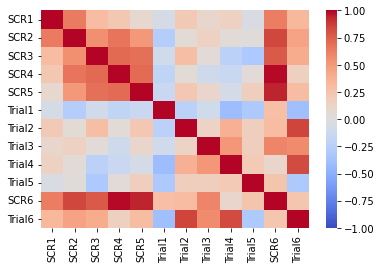

In [184]:
sns.heatmap(corTotalBoth[corTotalBoth.group=='VPTSD'].corr(), cmap='coolwarm', vmin = -1)

<AxesSubplot:>

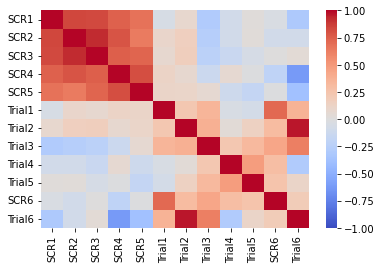

In [185]:
sns.heatmap(corTotalBoth[corTotalBoth.group=='VCC'].corr(), cmap='coolwarm', vmin = -1)

<AxesSubplot:>

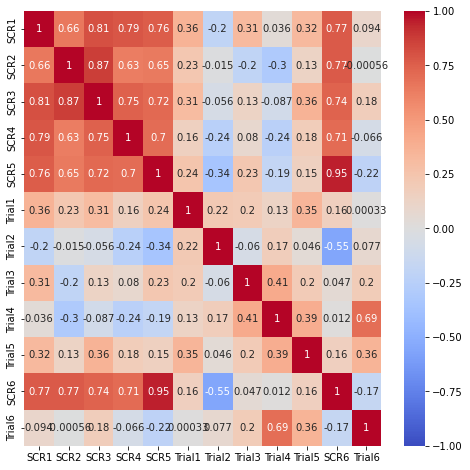

In [191]:
plt.figure(figsize=(8,8))
sns.heatmap(corTotalBoth[corTotalBoth.group=='HC'].corr(), cmap='coolwarm', vmin = -1,
           annot=True)

In [195]:
## Take Trial1 - SCR1 etc.
totalCor = corTotalBoth.corr()
# grab relevant correlations
trials = ['Trial1','Trial2','Trial3','Trial4', 'Trial5', 'Trial6']
scrs = ['SCR1', 'SCR2','SCR3','SCR4','SCR5', 'SCR6']

allCor = []
for t, s in zip(trials, scrs):
    print(t , s)
    allCor.append(totalCor.at[t, s])

Trial1 SCR1
Trial2 SCR2
Trial3 SCR3
Trial4 SCR4
Trial5 SCR5
Trial6 SCR6


In [200]:
# same for PTSD
## Take Trial1 - SCR1 etc.
totalCor = corTotalBoth[corTotalBoth.group=='VPTSD'].corr()
# grab relevant correlations
trials = ['Trial1','Trial2','Trial3','Trial4', 'Trial5', 'Trial6']
scrs = ['SCR1', 'SCR2','SCR3','SCR4','SCR5', 'SCR6']

allCorPT = []
for t, s in zip(trials, scrs):
    #print(t , s)
    allCorPT.append(totalCor.at[t, s])

In [201]:
# same for VCC
## Take Trial1 - SCR1 etc.
totalCor = corTotalBoth[corTotalBoth.group=='VCC'].corr()
# grab relevant correlations
trials = ['Trial1','Trial2','Trial3','Trial4', 'Trial5', 'Trial6']
scrs = ['SCR1', 'SCR2','SCR3','SCR4','SCR5', 'SCR6']

allCorCC = []
for t, s in zip(trials, scrs):
   # print(t , s)
    allCorCC.append(totalCor.at[t, s])

In [202]:
# same for HC
## Take Trial1 - SCR1 etc.
totalCor = corTotalBoth[corTotalBoth.group=='HC'].corr()
# grab relevant correlations
trials = ['Trial1','Trial2','Trial3','Trial4', 'Trial5', 'Trial6']
scrs = ['SCR1', 'SCR2','SCR3','SCR4','SCR5', 'SCR6']

allCorHC = []
for t, s in zip(trials, scrs):
    #print(t , s)
    allCorHC.append(totalCor.at[t, s])

In [203]:
print(f'PTSD {allCorPT}')
print(f'HC {allCorHC}')
print(f'CC {allCorCC}')

PTSD [-0.057710805117898153, 0.0465602299667143, 0.03655042153429669, -0.14819482248545157, 0.16683962711433617, 0.23891089525435327]
HC [0.3611210089843628, -0.01489690036974529, 0.13153338628248504, -0.24059882493233045, 0.1505146884772383, -0.17179091262731672]
CC [-0.05358788784791761, 0.15922684148562147, -0.2315941819360709, 0.06903198725799756, -0.1723692095389576, 0.1946362977761794]


Doesn't look interesting

1. Is correlation is indicator of learning
2. Uncoupling as predictor for extinction
Ifat - Try to use alpha with average coupling